In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [3]:
data = pd.read_csv("data/train.csv")

In [4]:
training = data[~data['MISSING_DATA']]

# adding date time, modified from given feature engineering notebook
getdate = lambda x : [tuple([i.year, i.month, i.day, i.hour, i.weekday()]) for i in [datetime.fromtimestamp(x["TIMESTAMP"])]][0]
training[["YR", "MON", "DAY", "HR", "WK"]] = training[["TIMESTAMP"]].apply(getdate, axis=1, result_type="expand")
training = training.drop(columns = ['TIMESTAMP'])

# adding trip time, using the given 15 second formula on polyline
training['TRIP_TIME'] = training['POLYLINE'].apply(lambda x : max(x.count(".")/2-1,0)*15)
training = training.drop(columns = ['POLYLINE'])

C:\Users\ishpa\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
og = training

In [40]:
ogs = og.sample(frac = 1)
training, testing = ogs[:ogs.shape[0]*8//10], ogs[ogs.shape[0]*8//10:]

In [41]:
def ohetrans(data, test=pd.DataFrame(), w = [1,1,1,1,1]):
    data = pd.concat([data,test])
    data = data.drop(columns = ['TRIP_ID','DAY_TYPE','MISSING_DATA','YR'])
    
    ones = pd.get_dummies(data['CALL_TYPE'])*w[0]
    ones = ones.join(pd.get_dummies(data['ORIGIN_STAND'])*w[1])
    ones = ones.join(pd.get_dummies(data['TAXI_ID'])*w[2])
        
#    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['DAY'])*w[4])).rename(columns = {i:f'd{i}' for i in range(31)})))
#    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['WK'])*w[3])).rename(columns = {0:'d0',1:'d1',2:'d2',3:'d3',4:'d4',5:'d5',6:'d6'})))

#    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['MON'])*w[4])).rename(columns = {i:f'm{i}' for i in range(12)})))
#    ones['MON'] = np.abs(data['MON']-6)/6*w[4]

    ones = ones.join(pd.get_dummies(((pd.get_dummies(data['HR'])*w[3])).rename(columns = {i:f'h{i}' for i in range(24)})))
#    ones['HR'] = np.abs(data['HR']-12)/12*w[5]

    ones = ones.join((pd.get_dummies(data['date'])*w[4]).rename(columns = {i:f'date{i}' for i in range(5)}))
    return ones.iloc[:-test.shape[0],:],ones.iloc[-test.shape[0]:,:]#.to_numpy()
    

In [42]:
days = [(8,14),(9,30),(10,6),(10,31),(12,21)]

narrows = [training[(training['MON'] == i[0])&(training['DAY']==i[1])].drop(columns = ['MON','DAY']).assign(date=j) for j,i in enumerate(days)]
tnarrows = [testing[(testing['MON'] == i[0])&(testing['DAY']==i[1])].drop(columns = ['MON','DAY']).assign(date=j) for j,i in enumerate(days)]

narrowed = pd.concat(narrows)
tnarrowed = pd.concat(tnarrows)
anarrowed = pd.concat([narrowed,tnarrowed])

In [43]:
Xtrain, Xtest = ohetrans(narrowed,tnarrowed)
Ytrain = narrowed['TRIP_TIME']
Ytest = tnarrowed['TRIP_TIME']

In [44]:
gbparameters = {
    'loss' : 'huber',
    'learning_rate' : 0.01,
    'n_estimators' : 500,
    'subsample' : 0.5, # (0,1]
    'criterion' : 'friedman_mse',
    'min_samples_split' : 10, # int [2,inf), float (0,1]
    'min_samples_leaf' : 5, # same as above, except can be 1
    'min_weight_fraction_leaf' : 0, # [0,0.5]
    'max_depth' : 5, # int or None
    'min_impurity_decrease' : 0.0, # float up to inf
    'random_state' : None, # seeding
    'max_features' : 3, # number of features for split
    'alpha' : 0.1,
    'verbose' : 1,
    'max_leaf_nodes' : None, # [2,inf)
    'warm_start' : False, # dont use
    'validation_fraction' : 0.1, # proportion for validation for early stopping
    'n_iter_no_change' : None, # look above
    'tol' : 1e-4, # look above
    'ccp_alpha' : 0.0 # something about pruning
}

In [45]:
gbrmdl = GradientBoostingRegressor(**gbparameters)

In [46]:
gbrmdl.fit(Xtrain,Ytrain)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       14254.7245           0.4976            3.77s
         2       14207.3264          44.2947            3.51s
         3       14195.6362         -39.9501            3.32s
         4       14218.0751          37.0077            3.43s
         5       14064.0204          50.0041            3.38s
         6       14462.5664         -34.8448            3.39s
         7       14060.3383         -20.1160            3.36s
         8       13926.8121          41.6659            3.34s
         9       14084.6612          15.8330            3.34s
        10       14130.4650          17.4903            3.32s
        20       14149.0129          36.6762            3.25s
        30       14039.1027          31.3630            3.18s
        40       14389.3304          34.8300            3.16s
        50       13840.0016         -56.4526            3.08s
        60       13931.9335           0.0489            3.01s
       

GradientBoostingRegressor(alpha=0.1, learning_rate=0.01, loss='huber',
                          max_depth=5, max_features=3, min_samples_leaf=5,
                          min_samples_split=10, min_weight_fraction_leaf=0,
                          n_estimators=500, subsample=0.5, verbose=1)

In [47]:
np.sqrt(np.sum((gbrmdl.predict(Xtest)-Ytest)**2)/Xtest.shape[0])

601.0632116855039

In [8]:
points = [14199.2390,14027.1045,14318.7396,14175.4570,14245.3705,14029.5471,14418.6014,14507.2483,14049.6226,14299.4548,14376.9247,13893.6353,13968.2603,14155.9717,13925.1476,13764.0407,13827.9374,13776.3519,13985.6360,13468.9091,13201.9891,13496.8218,13308.1267]
iteration = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]

Text(0, 0.5, 'Loss')

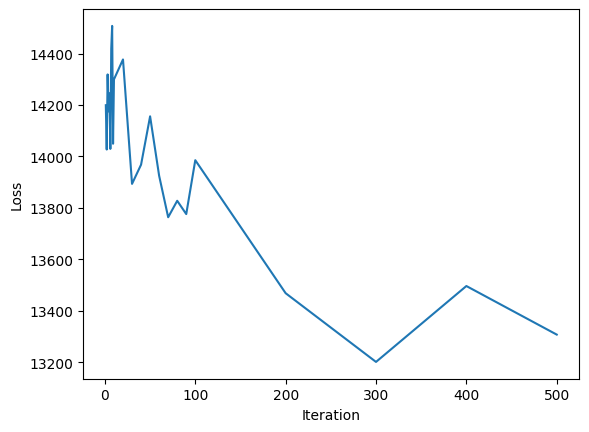

In [11]:
plt.plot(iteration, points)
plt.xlabel('Iteration')
plt.ylabel('Loss')